In [20]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import fbeta_score

def create_model(img_dim=(128, 128, 3)):
    input_tensor = Input(shape=img_dim)
    base_model = VGG16(include_top=False,
                       weights='imagenet',
                       input_shape=img_dim)
    
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Flatten()(x)
    output = Dense(17, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    return model

def predict(model, preprocessor, batch_size=128):
    """
    Launch the predictions on the test dataset as well as the additional test dataset
    :return:
        predictions_labels: list
            An array containing 17 length long arrays
        filenames: list
            File names associated to each prediction
    """
    generator = preprocessor.get_prediction_generator(batch_size)
    predictions_labels = model.predict_generator(generator=generator, verbose=1,
                                                 steps=len(preprocessor.X_test_filename) / batch_size)
    assert len(predictions_labels) == len(preprocessor.X_test), \
        "len(predictions_labels) = {}, len(preprocessor.X_test) = {}".format(
            len(predictions_labels), len(preprocessor.X_test))
    return predictions_labels, np.array(preprocessor.X_test)

def map_predictions(preprocessor, predictions, thresholds):
        """
        Return the predictions mapped to their labels
        :param predictions: the predictions from the predict() method
        :param thresholds: The threshold of each class to be considered as existing or not existing
        :return: the predictions list mapped to their labels
        """
        predictions_labels = []
        for prediction in predictions:
            labels = [preprocessor.y_map[i] for i, value in enumerate(prediction) if value > thresholds[i]]
            predictions_labels.append(labels)

        return predictions_labels

def fbeta(model, X_valid, y_valid):
    p_valid = model.predict(X_valid)
    return fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')

In [21]:
import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
# import vgg16
# import data_helper
# from data_helper import AmazonPreprocessor

import os
import sys
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from itertools import chain
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator


class AmazonPreprocessor:
    def __init__(self, train_jpeg_dir, train_csv_file, test_jpeg_dir, test_additional_jpeg_dir,
                 img_resize=(32, 32), validation_split=0.2, process_count=cpu_count()):
        """
        This class is used by the classifier to preprocess certains data, don't forget to call the init() method
        after an object from this class gets created
        :param validation_split: float
            Value between 0 and 1 used to split training set from validation set
        :param train_jpeg_dir: string
            The directory of the train files
        :param train_csv_file: string
            The path of the file containing the training labels
        :param test_jpeg_dir: string
            The directory of the all the test images
        :param test_additional_jpeg_dir: string
            The directory of the all the additional test images
        :param img_resize: tuple (int, int)
            The resize size of the original image given by the file_path argument
        :param process_count: int
            The number of process you want to use to preprocess the data.
            If you run into issues, lower this number. Its default value is equal to the number of core of your CPU
        """
        self.process_count = process_count
        self.validation_split = validation_split
        self.img_resize = img_resize
        self.test_additional_jpeg_dir = test_additional_jpeg_dir
        self.test_jpeg_dir = test_jpeg_dir
        self.train_csv_file = train_csv_file
        self.train_jpeg_dir = train_jpeg_dir
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.y_map = None
        self.X_test = None
        self.X_test_filename = None

    def init(self):
        """
        Initialize the preprocessor and preprocess required data for the classifier to use
        """
        self.X_train, self.y_train, self.X_val, self.y_val, self.y_map = self._get_train_data_files()
        # Contains all the test files including the additional ones
        self.X_test, self.X_test_filename = self._get_test_data_files()

        if not self.img_resize:
            self.img_resize = Image.open(self.X_test_filename[0]).size
            print("Default image size is", self.img_resize)

        # The validation data cannot be preprocessed in batches as we also need them to compute the f2 score
        self.X_val, self.y_val = self._preprocess_val_files()

    def get_train_generator(self, batch_size):
        """
        Returns a batch generator which transforms chunk of raw images into numpy matrices
        and then "yield" them for the classifier. Doing so allow to greatly optimize
        memory usage as the images are processed then deleted by chunks (defined by batch_size)
        instead of preprocessing them all at once and feeding them to the classifier.
        :param batch_size: int
            The batch size
        :return: generator
            The batch generator
        """
        # Image Augmentation
        datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)  # randomly flip images horizontally
        loop_range = len(self.X_train)
        while True:
            for i in range(loop_range):
                start_offset = batch_size * i

                # The last remaining files could be smaller than the batch_size
                range_offset = min(batch_size, loop_range - start_offset)

                # If we reached the end of the list then we break the loop
                if range_offset <= 0:
                    break

                batch_features = np.zeros((range_offset, *self.img_resize, 3))
                batch_labels = np.zeros((range_offset, len(self.y_train[0])))

                for j in range(range_offset):
                    # Maybe shuffle the index?
                    img = Image.open(self.X_train[start_offset + j])
                    img.thumbnail(self.img_resize)

                    # Augment the image `img` here

                    # Convert to RGB and normalize
                    img_array = np.asarray(img.convert("RGB"), dtype=np.float32)

                    img_array = img_array[:, :, ::-1]
                    # Zero-center by mean pixel
                    img_array[:, :, 0] -= 103.939
                    img_array[:, :, 1] -= 116.779
                    img_array[:, :, 2] -= 123.68

                    batch_features[j] = img_array
                    batch_labels[j] = self.y_train[start_offset + j]

                # Augment the images (using Keras allow us to add randomization/shuffle to augmented images)
                # Here the next batch of the data generator (and only one for this iteration)
                # is taken and returned in the yield statement
                yield next(datagen.flow(batch_features, batch_labels, range_offset))

    def get_prediction_generator(self, batch_size):
        """
        Returns a batch generator which transforms chunk of raw images into numpy matrices
        and then "yield" them for the classifier. Doing so allow to greatly optimize
        memory usage as the images are processed then deleted by chunks (defined by batch_size)
        instead of preprocessing them all at once and feeding them to the classifier.
        :param batch_size: int
            The batch size
        :return: generator
            The batch generator
        """

        # NO SHUFFLE HERE as we need our predictions to be in the same order as the inputs
        loop_range = len(self.X_test_filename)
        while True:
            for i in range(loop_range):
                start_offset = batch_size * i

                # The last remaining files could be smaller than the batch_size
                range_offset = min(batch_size, loop_range - start_offset)

                # If we reached the end of the list then we break the loop
                if range_offset <= 0:
                    break

                img_arrays = np.zeros((range_offset, *self.img_resize, 3))

                for j in range(range_offset):
                    img = Image.open(self.X_test_filename[start_offset + j])
                    img.thumbnail(self.img_resize)

                    # Convert to RGB and normalize
                    img_array = np.asarray(img.convert("RGB"), dtype=np.float32)

                    img_array = img_array[:, :, ::-1]
                    # Zero-center by mean pixel
                    img_array[:, :, 0] -= 103.939
                    img_array[:, :, 1] -= 116.779
                    img_array[:, :, 2] -= 123.68
                    img_array = img_array / 255

                    img_arrays[j] = img_array
                yield img_arrays

    def _get_class_mapping(self, *args):
        """
        :param args: list of arguments
            file_path: string
                The path of the image
            tags_str: string
                The associated tags as 1 string
            labels_map: dict {int: string}
                The map between the image label and their id
        :return: img_array, targets
            file_path: string
                The path to the file
            targets: Numpy array
                A 17 length vector
        """
        # Unpack the *args
        file_path, tags_str, labels_map = list(args[0])
        targets = np.zeros(len(labels_map))

        for t in tags_str.split(' '):
            targets[labels_map[t]] = 1
        return file_path, targets

    def _get_validation_split(self):
        train = pd.read_csv(self.train_csv_file)
        # mapping labels to integer classes
        flatten = lambda l: [item for sublist in l for item in sublist]
        labels = list(set(flatten([l.split(' ') for l in train['tags'].values])))
        label_map = {l: i for i, l in enumerate(labels)}

        y_train = []
        for f,tags in (train.values):
            targets = np.zeros(len(label_map))
            for t in tags.split(' '):
                targets[label_map[t]] = 1
            y_train.append(targets)

        y_train = np.array(y_train, np.uint8)
        trn_index = []
        val_index = []
        index = np.arange(len(train))
        for i in (range(len(label_map))):
            sss = StratifiedShuffleSplit(n_splits=2, test_size=self.validation_split, random_state=i)
            for train_index, test_index in sss.split(index,y_train[:,i]):
                X_train, X_test = index[train_index], index[test_index]
            # to ensure there is no repetetion within each split and between the splits
            trn_index = trn_index + list(set(X_train) - set(trn_index) - set(val_index))
            val_index = val_index + list(set(X_test) - set(val_index) - set(trn_index))
        return np.array(trn_index), np.array(val_index)

    def _get_train_data_files(self):
        labels_df = pd.read_csv(self.train_csv_file)
        x_train_files, y_train_files = [], []
        x_val_files, y_val_files = [], []
        train_files, train_tags = [], []
        val_files, val_tags = [], []

        files_path = []
        tags_list = []
        for file_name, tags in labels_df.values:
            files_path.append('{}/{}.jpg'.format(self.train_jpeg_dir, file_name))
            tags_list.append(tags)


        if self.validation_split != 0:

            trn_index, val_index = self._get_validation_split()
            for index in trn_index:
                train_files.append(files_path[index])
                train_tags.append(tags_list[index])
            for index in val_index:
                val_files.append(files_path[index])
                val_tags.append(tags_list[index])

        else:
            train_files = files_path
            train_tags = tags_list


        labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))
        y_map = {l: i for i, l in enumerate(labels)}

        with ThreadPoolExecutor(self.process_count) as pool:
            for file_name, targets in tqdm(pool.map(self._get_class_mapping,
                                                    [(file_name, tags, y_map)
                                                     for file_name, tags in zip(train_files, train_tags)]),
                                           total=len(train_files)):
                x_train_files.append(file_name)
                y_train_files.append(targets)

        if self.validation_split != 0:
            with ThreadPoolExecutor(self.process_count) as pool:
                for file_name, targets in tqdm(pool.map(self._get_class_mapping,
                                                        [(file_name, tags, y_map)
                                                         for file_name, tags in zip(val_files, val_tags)]),
                                               total=len(val_files)):
                    x_val_files.append(file_name)
                    y_val_files.append(targets)

        return [x_train_files, y_train_files, x_val_files, y_val_files, {v: k for k, v in y_map.items()}]

    def _val_transform_to_matrices(self, *args):
        """
        :param args: list of arguments
            file_name: string
                The name of the image
            :return: img_array, file_name
                img_array: Numpy array
                    The image from the file_path as a numpy array resized with img_resize
                file_name: string
                    The name of the test image
            """
        file_path, val_labels = list(args[0])
        img = Image.open(file_path)
        img.thumbnail(self.img_resize)

        # Augment the image `img` here

        # Convert to RGB and normalize
        img_array = np.array(img.convert("RGB"), dtype=np.float32)
        img_array = img_array[:, :, ::-1]
        # Zero-center by mean pixel
        img_array[:, :, 0] -= 103.939
        img_array[:, :, 1] -= 116.779
        img_array[:, :, 2] -= 123.68
        img_array = img_array / 255

        return img_array, val_labels

    def _preprocess_val_files(self):
        """
        Transform the images to ready to use data for the CNN
        :param val_labels: list
            List of file labels
        :param val_files: list
            List of file path
        :param process_count: int
            The number of process you want to use to preprocess the data.
            If you run into issues, lower this number. Its default value is equal to the number of core of your CPU
        :return: The images matrices and labels as [x_test, x_test_filename]
            x_test: The X test values as a numpy array
            x_test_filename: The files name of each test images in the same order as the x_test arrays
        """
        x = []
        final_val_labels = []

        # Multiprocess transformation, the map() function take a function as a 1st argument
        # and the argument to pass to it as the 2nd argument. These arguments are processed
        # asynchronously on threads defined by process_count and their results are stored in
        # the x_test and x_test_filename lists
        print("Transforming val dataset...")
        sys.stdout.flush()
        with ThreadPoolExecutor(self.process_count) as pool:
            for img_array, targets in tqdm(pool.map(self._val_transform_to_matrices,
                                                    [(file_path, labels)
                                                     for file_path, labels in zip(self.X_val, self.y_val)]),
                                           total=len(self.X_val)):
                x.append(img_array)
                final_val_labels.append(targets)
        ret = [np.array(x), np.array(final_val_labels)]
        print("Done. Size consumed by validation matrices {} mb".format(ret[0].nbytes / 1024 / 1024))
        sys.stdout.flush()
        return ret

    def _get_test_data_files(self):
        files_name = os.listdir(self.test_jpeg_dir)
        files_name_add = os.listdir(self.test_additional_jpeg_dir)
        # ! hstack is deprecated
        X_test_filename = np.hstack(([name.split(".")[0] for name in files_name],
                                     [name.split(".")[0] for name in files_name_add]))
        X_test_file_path = np.hstack(([self.test_jpeg_dir + "/" + name for name in files_name],
                                      [self.test_additional_jpeg_dir + "/" + name for name in files_name_add]))
        return X_test_filename, X_test_file_path


def get_jpeg_data_files_paths():
    """
    Returns the input file folders path
    :return: list of strings
        The input file paths as list [train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file]
    """

    data_root_folder = os.path.abspath("../input/")
    train_jpeg_dir = os.path.join(data_root_folder, 'train-jpg')
    test_jpeg_dir = os.path.join(data_root_folder, 'test-jpg')
    test_jpeg_additional = os.path.join(data_root_folder, 'test-jpg-additional')
    train_csv_file = os.path.join(data_root_folder, 'train_v2.csv')
    return [train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file]

In [22]:
import tensorflow.keras.applications as apps

In [23]:
#competition_name = "planet-understanding-the-amazon-from-space"

train_path = "../input/planets-dataset/planet/planet/train-jpg"
test_path= "../input/planets-dataset/planet/planet/test-jpg"
test_additional_path= "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
train_labels = "../input/planets-dataset/planet/planet/train_classes.csv"
sample_submission_labels = '../input/planets-dataset/planet/planet/sample_submission.csv'
#destination_path = "../input/"
#is_datasets_present = False

In [24]:
df = pd.read_csv(train_labels)
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [25]:
sample = pd.read_csv(sample_submission_labels)
print(sample.shape)
sample.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


So, we are given around 40.000 training images.

In [26]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'cultivation', 'water', 'selective_logging', 'blow_down', 'habitation', 'bare_ground', 'agriculture', 'road', 'slash_burn', 'cloudy', 'primary', 'partly_cloudy', 'conventional_mine', 'artisinal_mine', 'blooming', 'clear', 'haze'}


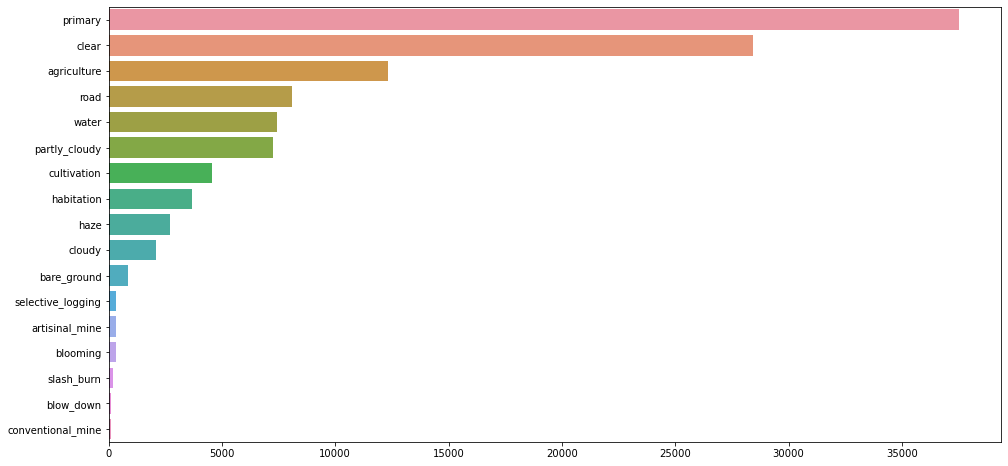

In [27]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [28]:
random_seed = 42
#random.seed(random_seed)
np.random.seed(random_seed)

# Tag counts


In [29]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [30]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411


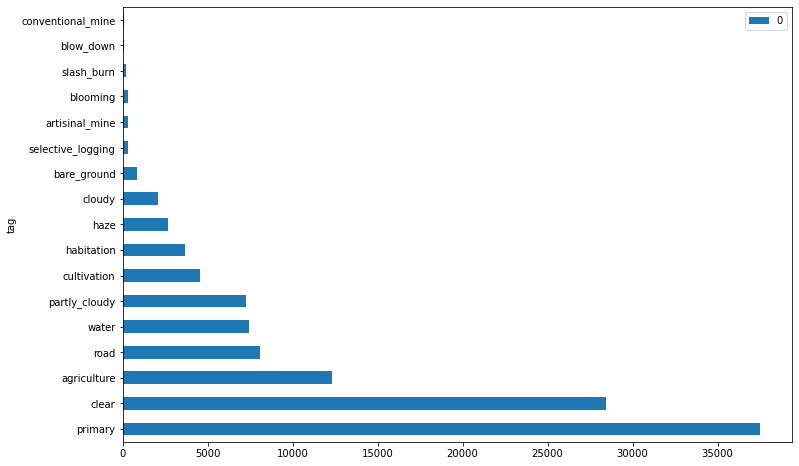

In [31]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

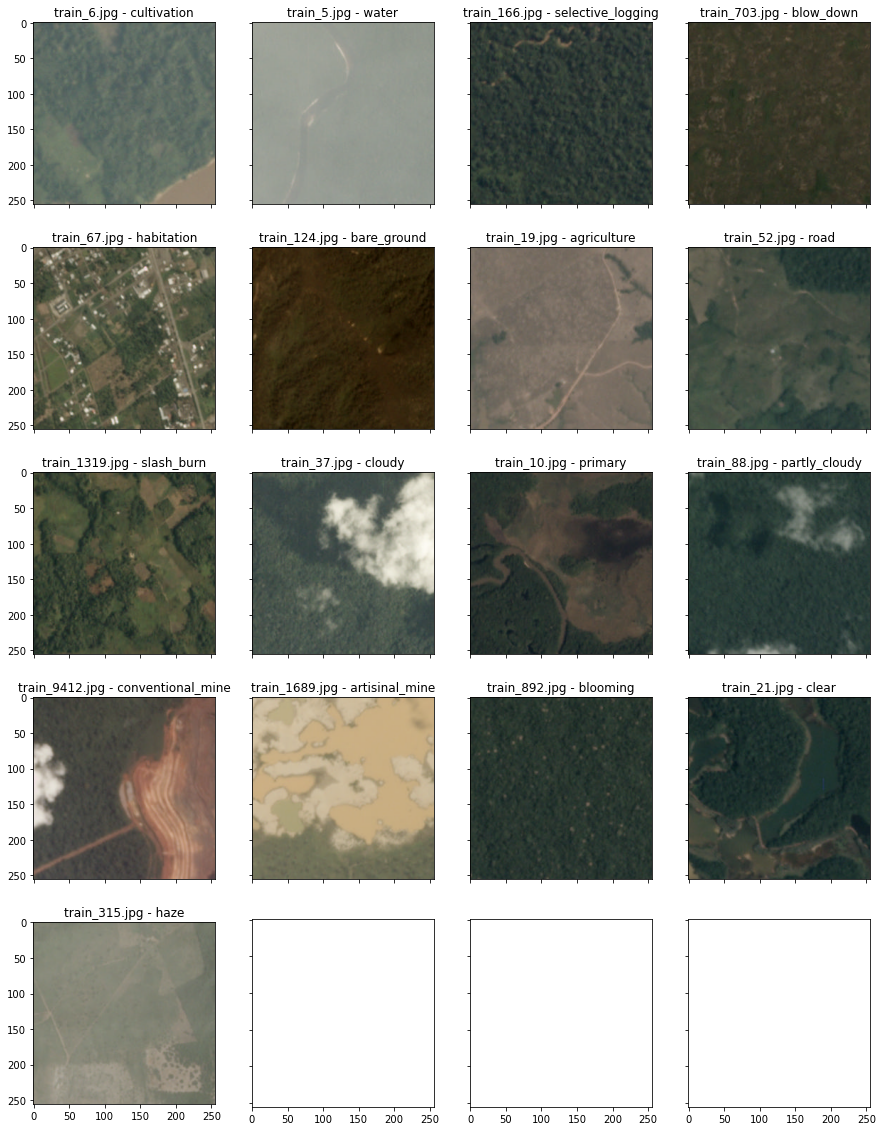

In [32]:
images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread('../input/planets-dataset/planet/planet/train-jpg/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

In [33]:
img_resize = (128, 128) # The resize size of each image ex: (64, 64) or None to use the default image size
validation_split_size = 0.2

In [34]:
preprocessor = AmazonPreprocessor(train_path, train_labels, test_path, test_additional_path, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 337868.00it/s]


Transforming val dataset...


100%|██████████| 8096/8096 [00:09<00:00, 838.70it/s]


Done. Size consumed by validation matrices 1518.0 mb


In [35]:

print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [36]:

model = create_model(img_dim=(128, 128, 3))
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [37]:
# IMG_SHAPE = (128, 128, 3)
# model = apps.MobileNetV2 (input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# model.summary()

In [39]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 20
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps, epochs=5, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/5
  20/1619 [..............................] - ETA: 1:51:02 - loss: 0.2189 - accuracy: 0.0225

KeyboardInterrupt: 

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

KeyError: 'loss'

In [42]:
#model.load_weights("weights/weights.best.hdf5")
#print("Weights loaded")

In [55]:
fbeta_score = fbeta(model, X_val, y_val)

fbeta_score

In [45]:

predictions, x_test_filename = predict(model, preprocessor, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

479/478 [==============================] - 3694s 8s/step
Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions (test_26597) entry:
[0.10490307 0.00307119 0.0201717  0.01721114 0.00218824 0.5738405
 0.16106296 0.00183839 0.03747535 0.03683451 0.21626756 0.05525687
 0.898938   0.10927859 0.01254219 0.00330919 0.20034188]


In [46]:
thresholds = [0.2] * len(labels_set)

In [47]:
predicted_labels = map_predictions(preprocessor, predictions, thresholds)


In [48]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [49]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

Predictions rows: 122382


,image_name,tags
0,test_26597,clear haze primary water
1,test_27087,clear haze primary
2,test_35735,clear cloudy haze primary water
3,test_18177,clear haze primary
4,test_35781,clear haze primary


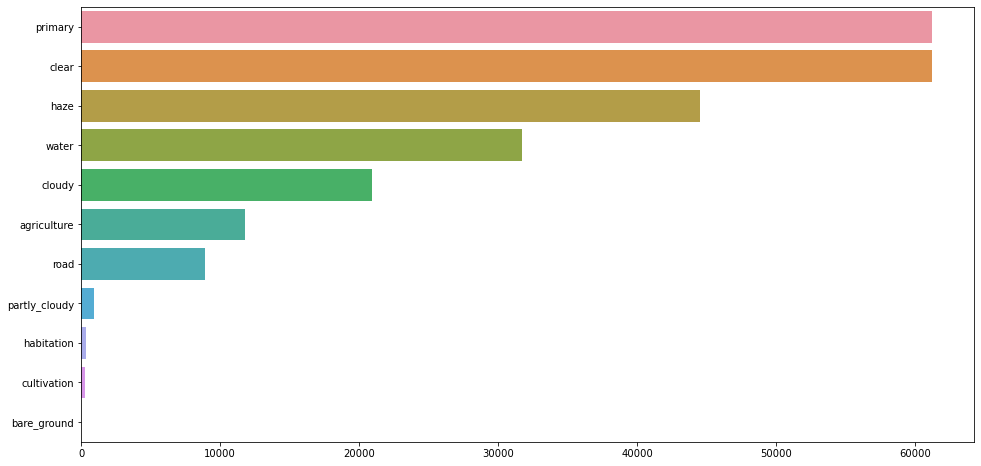

In [50]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [52]:
final_df.to_csv('submission_file1.csv', index=False)

In [56]:
#!pip install jovian
import jovian
jovian.commit(project= 'Amzon Forest-DL-Tf', Environment = None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/troublem1/Amzon Forest-DL-Tf


<IPython.core.display.Javascript object>